In [ ]:
!pip install -q kaggle
from google.colab import files
uploaded= files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist

100% 68.8M/68.8M [00:01<00:00, 53.7MB/s]



In [ ]:
!unzip /content/fashionmnist.zip

Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/content/fashion-mnist_train.csv')

In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [ ]:
Y_train

array([5, 9, 5, ..., 0, 3, 4])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with sigmoid activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{sigmoid}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [ ]:
#def init_params():
W1 = np.random.randn(10, 784)
b1 = np.random.randn(10, 1)
W2 = np.random.randn(10, 10)
b2 = np.random.randn(10, 1) 
    #return W1, b1, W2, b2

def sigmoid(Z,X):
  M= 1/(1+np.exp(-(W1.dot(X) + b1)))
  return M

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1,X)
    #Z3 = W3.dot(A1) + b3
    #A3 = sigmoid(Z3,A1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def sigmoid_deriv(Z):
  M= 1/(1+np.exp(-Z))
  return (M*(1-M))

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * sigmoid_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    #W1, b1, W2, b2 = init_params()
  W1 = np.random.randn(64, 784)
  b1 = np.random.randn(64, 1)
  W2 = np.random.randn(64,10)
  b2 = np.random.randn(10, 1) 
  #W3= np.random.randn(10,10)
  #b3= np.random.randn(10,1)
  for i in range(iterations):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    if i % 10 == 0:
      print("Iteration: ", i)
      predictions = get_predictions(A2)
      print(get_accuracy(predictions, Y))
  return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 1.1, 500)

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  2


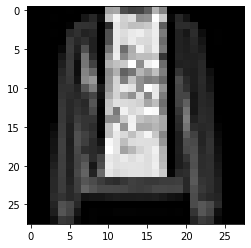

Prediction:  [8]
Label:  8


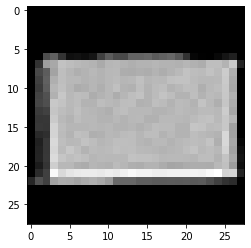

Prediction:  [7]
Label:  7


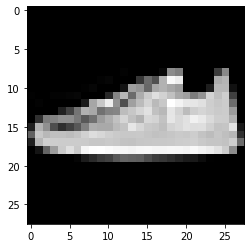

Prediction:  [2]
Label:  4


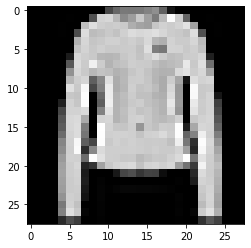

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[9 1 2 7 3 1 8 3 9 0 7 0 1 8 3 5 1 4 8 4 5 2 9 2 9 2 9 2 2 3 1 8 5 0 0 3 2
 9 8 8 5 2 8 2 8 0 8 3 5 9 1 4 2 1 9 0 4 2 3 1 0 4 3 5 7 1 0 9 0 3 4 3 5 7
 8 5 5 3 2 0 0 2 3 5 9 5 4 0 0 0 0 1 4 8 1 5 1 4 1 1 9 4 9 5 1 1 8 1 7 2 8
 9 8 6 5 7 4 0 3 6 9 2 1 6 3 7 8 1 4 5 1 8 6 7 0 1 9 0 4 1 2 8 4 8 3 2 0 7
 0 4 3 7 9 4 4 2 3 1 8 6 1 3 0 0 3 2 3 0 3 2 1 4 2 7 8 2 6 9 4 2 9 6 2 2 0
 9 5 9 3 8 4 7 0 2 8 9 5 6 0 2 8 7 7 4 1 1 7 0 7 2 9 5 0 9 1 6 0 1 8 8 7 3
 3 2 5 2 5 3 5 9 9 5 2 8 1 0 0 3 7 3 7 1 3 0 6 0 3 9 5 7 7 4 4 7 8 0 4 1 9
 5 7 9 0 2 4 5 2 4 3 3 8 2 6 4 2 8 1 0 9 0 5 1 2 7 3 8 2 0 6 7 9 3 4 1 4 8
 4 7 2 7 2 1 3 4 5 8 5 9 0 2 3 6 7 8 2 7 3 1 0 1 8 9 4 0 5 3 7 3 3 9 9 5 6
 5 0 6 3 9 2 9 4 4 5 1 0 9 0 8 8 4 0 1 9 8 2 2 9 4 1 0 1 7 6 3 0 7 8 3 7 3
 1 8 1 4 9 8 7 9 5 2 7 8 2 3 0 1 9 2 2 0 8 7 1 4 1 9 9 5 8 1 4 5 7 8 1 5 8
 4 0 8 2 2 0 5 0 2 0 3 3 9 9 0 4 5 3 0 0 9 6 9 9 9 5 4 1 2 3 9 7 3 4 5 8 4
 4 5 8 9 4 3 9 3 3 2 7 1 9 3 1 1 8 0 4 6 9 1 7 4 8 5 9 0 2 2 7 9 3 9 2 9 7
 1 8 8 2 7 9 5 1 4 2 5 8 

0.746